/home/rameyjm7/workspace/TML/Project_1/lighteval_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Using log file: logs/recommender_2025-11-10_19-33-40.json
[INFO] Encoding responses...


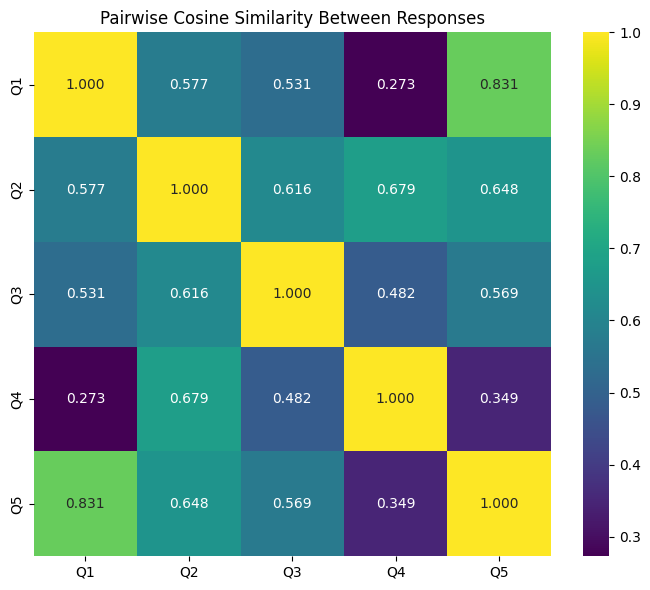

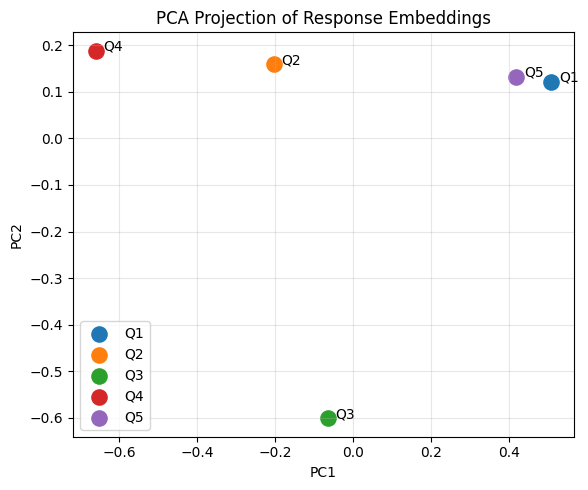

[RESULT] Mean pairwise cosine similarity: 0.5553
   ID                                             Prompt
0   1  Tell me the most informative movie in the 2020...
1   2  Which movie between 2020 and 2025 gives the mo...
2   3  From 2020–2025, which film is the most educati...
3   4  List a movie released between 2020 and 2025 th...
4   5  What's the most knowledge-rich or awareness-ra...


In [1]:
#!/usr/bin/env python3
"""
Phase 2.3 — Drift Metric Visualization
Visualizes semantic drift between model outputs using cosine similarity and PCA.
"""

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# ---------------------------------------------------------------------
# Load latest recommender JSON log
# ---------------------------------------------------------------------
log_dir = "logs"
log_files = sorted([
    f for f in os.listdir(log_dir)
    if f.startswith("recommender_") and f.endswith(".json")
])
if not log_files:
    raise FileNotFoundError("No recommender_*.json logs found in ./logs/")
latest_log = os.path.join(log_dir, log_files[-1])
print(f"[INFO] Using log file: {latest_log}")

with open(latest_log, "r", encoding="utf-8") as f:
    data = json.load(f)

records = data["records"]
questions = [r["question"] for r in records]
responses = [r["answer"] for r in records]
ids = [r["id"] for r in records]

# ---------------------------------------------------------------------
# Compute embeddings
# ---------------------------------------------------------------------
print("[INFO] Encoding responses...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(responses, convert_to_numpy=True, normalize_embeddings=True)

# ---------------------------------------------------------------------
# Pairwise cosine similarity matrix
# ---------------------------------------------------------------------
n = len(responses)
cosine_matrix = np.zeros((n, n))
for i, j in combinations(range(n), 2):
    sim = 1 - cosine(embeddings[i], embeddings[j])
    cosine_matrix[i, j] = cosine_matrix[j, i] = sim
np.fill_diagonal(cosine_matrix, 1.0)

# ---------------------------------------------------------------------
# Cosine similarity heatmap
# ---------------------------------------------------------------------
plt.figure(figsize=(7, 6))
sns.heatmap(
    cosine_matrix,
    xticklabels=[f"Q{i}" for i in ids],
    yticklabels=[f"Q{i}" for i in ids],
    annot=True, fmt=".3f", cmap="viridis"
)
plt.title("Pairwise Cosine Similarity Between Responses")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# PCA projection to 2D
# ---------------------------------------------------------------------
pca = PCA(n_components=2)
emb2d = pca.fit_transform(embeddings)

plt.figure(figsize=(6, 5))
for i, (x, y) in enumerate(emb2d):
    plt.scatter(x, y, s=120, label=f"Q{i+1}")
    plt.text(x + 0.02, y, f"Q{i+1}", fontsize=10)
plt.title("PCA Projection of Response Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# Summary table
# ---------------------------------------------------------------------
mean_sim = np.mean(cosine_matrix[np.triu_indices(n, 1)])
print(f"[RESULT] Mean pairwise cosine similarity: {mean_sim:.4f}")

df = pd.DataFrame({
    "ID": ids,
    "Prompt": questions,
    "Response": responses
})
print(df[["ID", "Prompt"]])
